In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras 

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16


dataset = pd.read_csv(r"C:\Users\Gayathri Anil\Downloads\driver_imgs_list.csv")
dataset.head(5)

subject classname            img
0    p012        c0  img_10206.jpg
1    p012        c0  img_27079.jpg
2    p012        c0  img_50749.jpg
3    p012        c0  img_97089.jpg
4    p012        c0  img_37741.jpg

In [3]:
# Groupby subjects
by_drivers = dataset.groupby('subject') 
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  20  unique drivers
There is a mean of  1746  images by driver.


In [4]:
NUMBER_CLASSES = 10 # 10 classes

In [5]:
# Load Training Dataset
def load_train(img_rows, img_cols, color_type=3):
    train_images = [] 
    train_labels = []
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join(r"C:\Users\Gayathri Anil\Downloads\imgs\train", 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

# Read and Normalize Training Data
def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = to_categorical(labels, NUMBER_CLASSES)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    return x_train, x_test, y_train, y_test

# Load Test Dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join(r"C:\Users\Gayathri Anil\Downloads\imgs\test", '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

# Read and Normalize Sampled Test Data
def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids  

# Utility function to load images with OpenCV
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols))
    return img

# Constants
img_rows = 64
img_cols = 64
color_type = 1  # Grey
NUMBER_CLASSES = 10  # Number of classes

# Load and normalize training data
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# Load and normalize sampled test data
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:02<00:23,  2.66s/it]

Loading directory c1


 20%|██        | 2/10 [00:04<00:19,  2.40s/it]

Loading directory c2


 30%|███       | 3/10 [00:07<00:17,  2.44s/it]

Loading directory c3


 40%|████      | 4/10 [00:09<00:13,  2.30s/it]

Loading directory c4


 50%|█████     | 5/10 [00:11<00:11,  2.30s/it]

Loading directory c5


 60%|██████    | 6/10 [00:14<00:09,  2.36s/it]

Loading directory c6


 70%|███████   | 7/10 [00:16<00:06,  2.30s/it]

Loading directory c7


 80%|████████  | 8/10 [00:18<00:04,  2.21s/it]

Loading directory c8


 90%|█████████ | 9/10 [00:20<00:02,  2.14s/it]

Loading directory c9


  4%|▍         | 200/4961 [00:00<00:06, 748.40it/s]


## Part 2 : EDA  <a class="anchor" id="chapter2"></a>

In [6]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob(r"C:\Users\Gayathri Anil\Downloads\imgs\train"))]
test_files_size = len(np.array(glob(os.path.join(r"C:\Users\Gayathri Anil\Downloads\imgs\test", '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 22423 total images.

There are 13969 training images.
There are 1 total training categories.
There are 3493 validation images.
There are 4961 test images.


### Data visualisation

Number of images by category

In [8]:
import plotly.express as px

px.histogram(dataset, x="classname", color="classname", title="Number of images by categories ")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'classname=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'c0',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'c0',
              'offsetgroup': 'c0',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['c0', 'c0', 'c0', ..., 'c0', 'c0', 'c0'], dtype=object),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'classname=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'c1',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'c1',
              'offsetgroup': 'c1',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['c1', 'c1', 'c1', ..., 'c1', 'c1', 'c1'], dtype=object),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'classname=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'c2',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': 'c2',
              'offsetgroup': 'c2',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['c2', 'c2', 'c2', ..., 'c2', 'c2', 'c2'], dtype=object),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'classname=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'c3',
              'marker': {'color': '#ab63fa', 'pattern': {'shape': ''}},
              'name': 'c3',
              'offsetgroup': 'c3',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['c3', 'c3', 'c3', ..., 'c3', 'c3', 'c3'], dtype=object),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'classname=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'c4',
              'marker': {'color': '#FFA15A', 'pattern': {'shape': ''}},
              'name': 'c4',
              'offsetgroup': 'c4',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['c4', 'c4', 'c4', ..., 'c4', 'c4', 'c4'], dtype=object),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'classname=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'c5',
              'marker': {'color': '#19d3f3', 'pattern': {'shape': ''}},
              'name': 'c5',
              'offsetgroup': 'c5',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['c5', 'c5', 'c5', ..., 'c5', 'c5', 'c5'], dtype=object),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'hovertemplate': 'classname=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': 'c6',
              'marker': {'color': '#FF6692', 'pattern': {'shape': ''}},
              'name': 'c6',
              'offsetgroup': 'c6',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['c6', 'c6', 'c6', ..., 'c6', 'c6', 'c6'], dtype=object),
              'xaxis': 'x',
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bi

--> It is well distributed

In [9]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'driver_id=%{x}<br>sum of Counts=%{y}<extra></extra>',
              'legendgroup': 'p021',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': 'p021',
              'offsetgroup': 'p021',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['p021'], dtype=object),
              'xaxis': 'x',
              'y': array([2474], dtype=int64),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'driver_id=%{x}<br>sum of Counts=%{y}<extra></extra>',
              'legendgroup': 'p022',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': 'p022',
              'offsetgroup': 'p022',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['p022'], dtype=object),
              'xaxis': 'x',
              'y': array([2466], dtype=int64),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'driver_id=%{x}<br>sum of Counts=%{y}<extra></extra>',
              'legendgroup': 'p024',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': 'p024',
              'offsetgroup': 'p024',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['p024'], dtype=object),
              'xaxis': 'x',
              'y': array([2452], dtype=int64),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'driver_id=%{x}<br>sum of Counts=%{y}<extra></extra>',
              'legendgroup': 'p026',
              'marker': {'color': '#ab63fa', 'pattern': {'shape': ''}},
              'name': 'p026',
              'offsetgroup': 'p026',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['p026'], dtype=object),
              'xaxis': 'x',
              'y': array([2392], dtype=int64),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'driver_id=%{x}<br>sum of Counts=%{y}<extra></extra>',
              'legendgroup': 'p066',
              'marker': {'color': '#FFA15A', 'pattern': {'shape': ''}},
              'name': 'p066',
              'offsetgroup': 'p066',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['p066'], dtype=object),
              'xaxis': 'x',
              'y': array([2068], dtype=int64),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'driver_id=%{x}<br>sum of Counts=%{y}<extra></extra>',
              'legendgroup': 'p049',
              'marker': {'color': '#19d3f3', 'pattern': {'shape': ''}},
              'name': 'p049',
              'offsetgroup': 'p049',
              'orientation': 'v',
              'showlegend': True,
              'type': 'histogram',
              'x': array(['p049'], dtype=object),
              'xaxis': 'x',
              'y': array([2022], dtype=int64),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'bingroup': 'x',
              'histfunc': 'sum',
              'hovertemplate': 'driver_id=%{x}<br>sum of Counts=%{y}<extra></extra>',
              'legendgroup': 'p051',
              'marker': {'

### Images overview

Let's take a look at the various images in the dataset.
* I'll plot an image for each of the 10 classes.

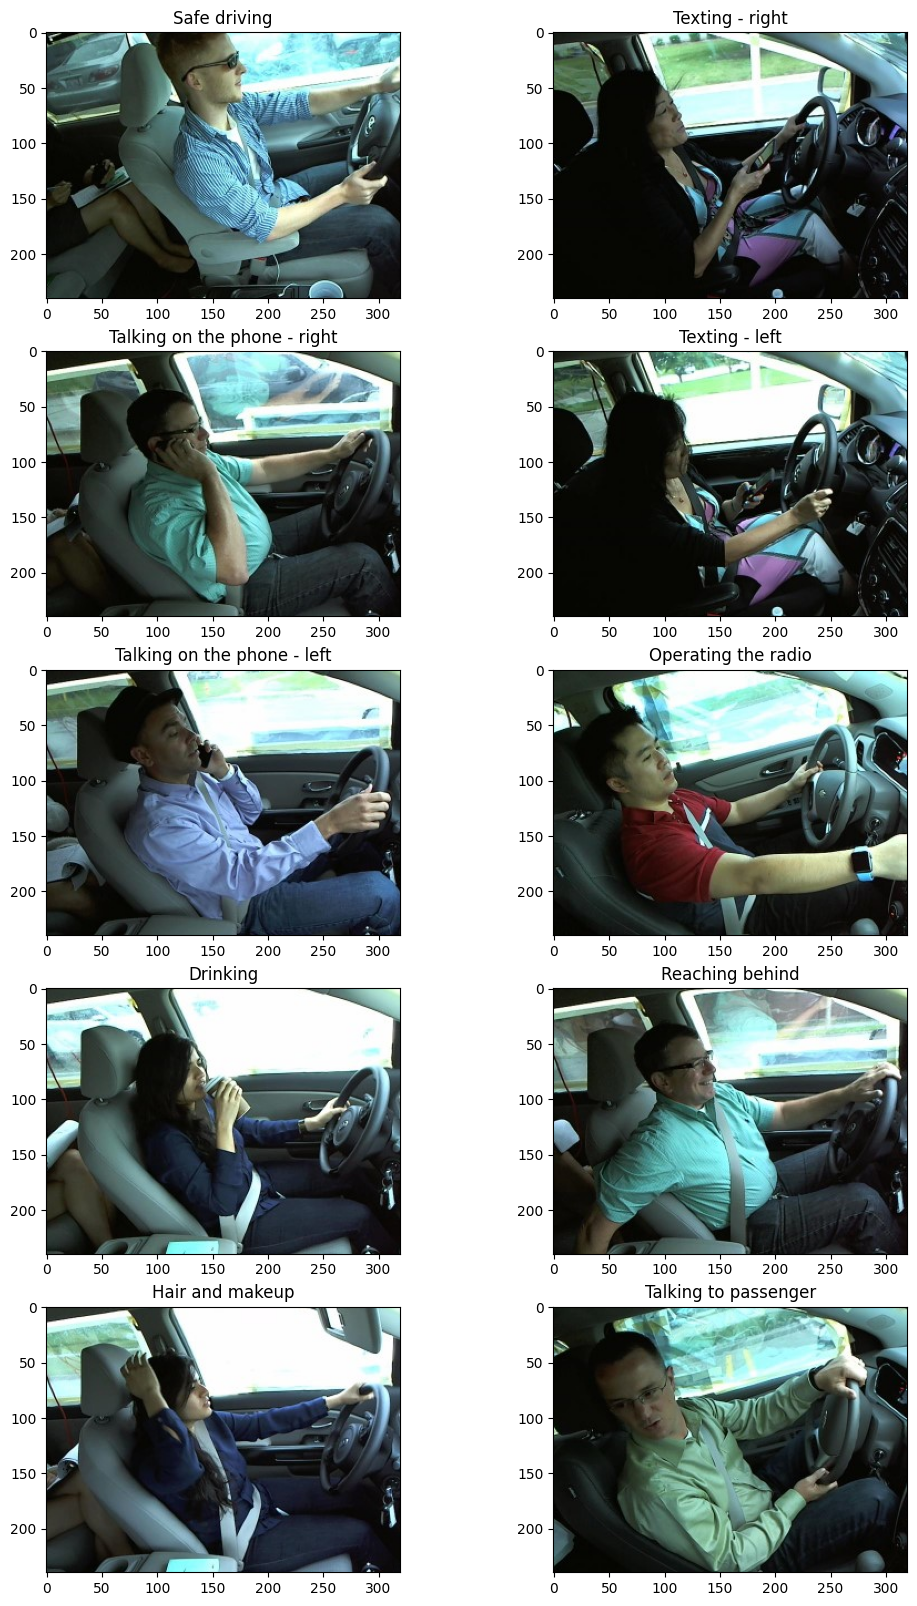

In [10]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = "C:\\Users\\Gayathri Anil\\Downloads\\imgs\\train\\"

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [11]:
def create_submission(predictions, test_id, info):
    """
    Submission function for participating to the competition
    """
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_id, index=result.index)
    
    now = datetime.datetime.now()
    
    if not os.path.isdir('kaggle_submissions'):
        os.mkdir('kaggle_submissions')

    suffix = "{}_{}".format(info,str(now.strftime("%Y-%m-%d-%H-%M")))
    sub_file = os.path.join('kaggle_submissions', 'submission_' + suffix + '.csv')
    
    result.to_csv(sub_file, index=False)
    
    return sub_file

In [12]:
# Number of batch size and epochs
batch_size = 40 #40
nb_epoch = 6 #10

In [13]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.keras', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#callbacks = [checkpointer, es]

In [14]:
def create_model():
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [15]:
model = create_model()

# More details about the layers
model.summary()

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                        

#### Training model

In [16]:
history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

#model.load_weights('saved_models/weights_best_vanilla.hdf5')
print('History of the training',history.history)

Epoch 1/6
350/350 [==============================] - 131s 370ms/step - loss: 1.2668 - accuracy: 0.5931 - val_loss: 0.5846 - val_accuracy: 0.8471
Epoch 2/6
350/350 [==============================] - 141s 403ms/step - loss: 0.3422 - accuracy: 0.8902 - val_loss: 0.1475 - val_accuracy: 0.9651
Epoch 3/6
350/350 [==============================] - 142s 405ms/step - loss: 0.2024 - accuracy: 0.9379 - val_loss: 0.2551 - val_accuracy: 0.9324
Epoch 4/6
350/350 [==============================] - 152s 434ms/step - loss: 0.1497 - accuracy: 0.9535 - val_loss: 0.0883 - val_accuracy: 0.9782
Epoch 5/6
350/350 [==============================] - 131s 375ms/step - loss: 0.1138 - accuracy: 0.9666 - val_loss: 0.0714 - val_accuracy: 0.9854
Epoch 6/6
350/350 [==============================] - 139s 397ms/step - loss: 0.0995 - accuracy: 0.9696 - val_loss: 0.0602 - val_accuracy: 0.9883
History of the training {'loss': [1.2667853832244873, 0.3421706557273865, 0.20243945717811584, 0.14973783493041992, 0.113838315010

#### Prediction on test set

In [18]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [19]:
score1 = model.evaluate(x_test, y_test, verbose=1)

110/110 [==============================] - 9s 77ms/step - loss: 0.0602 - accuracy: 0.9883


In [20]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.060153085738420486
Accuracy:  98.82622361183167  %


1/1 [==============================] - 0s 413ms/step
Y prediction: [[6.0580601e-07 4.7592289e-06 3.1112229e-06 3.5536968e-10 1.7857800e-06
  6.1528906e-09 7.9445178e-03 1.2170810e-06 9.9202263e-01 2.1376016e-05]]
Predicted: Hair and makeup


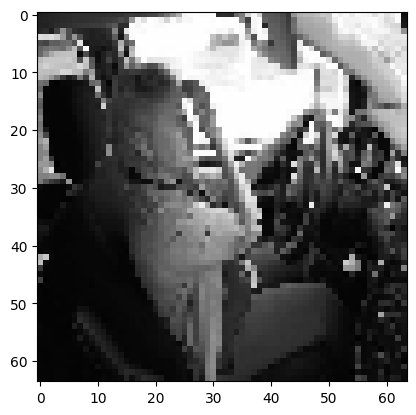

1/1 [==============================] - 0s 30ms/step
Y prediction: [[2.0728104e-10 2.9109947e-11 1.4993354e-07 2.4111713e-13 1.6436658e-08
  9.9999619e-01 3.6667150e-06 1.4161925e-13 9.7625449e-11 1.7171278e-08]]
Predicted: Operating the radio


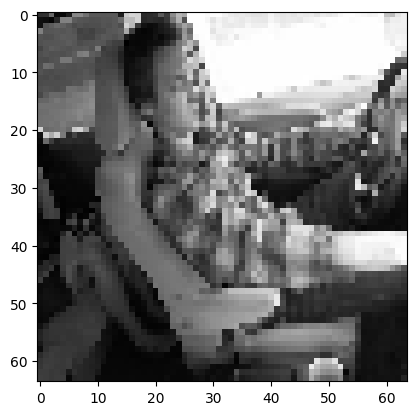

1/1 [==============================] - 0s 28ms/step
Y prediction: [[1.5177915e-05 9.9995959e-01 2.4404997e-06 3.0340246e-07 2.7415771e-07
  1.1427770e-10 1.2486667e-05 5.4449638e-06 1.2676791e-06 3.0626259e-06]]
Predicted: Texting - right


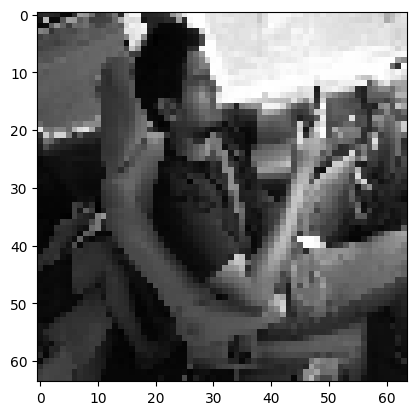

1/1 [==============================] - 0s 30ms/step
Y prediction: [[4.7881649e-10 1.4748349e-07 2.3771229e-10 5.5436467e-14 1.9171373e-11
  4.6997908e-14 1.3912528e-06 9.9999785e-01 5.7738924e-07 4.7190256e-09]]
Predicted: Reaching behind


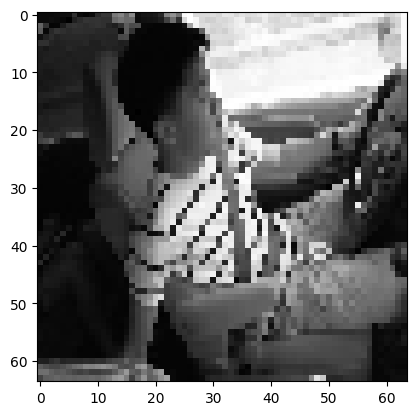

1/1 [==============================] - 0s 30ms/step
Y prediction: [[3.6881201e-10 4.6878486e-17 7.9989448e-10 1.4169754e-13 7.5105486e-09
  9.9999952e-01 2.1600128e-08 5.9378683e-12 1.7986283e-11 4.2730281e-07]]
Predicted: Operating the radio


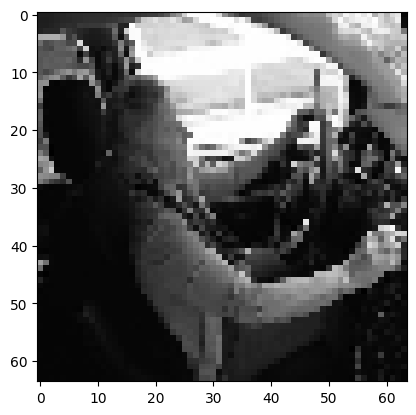

1/1 [==============================] - 0s 30ms/step
Y prediction: [[2.6388414e-02 2.8518885e-01 6.8543965e-01 1.6599065e-03 1.4215017e-05
  6.9610019e-07 3.7410975e-04 2.5152218e-05 4.0152136e-05 8.6891872e-04]]
Predicted: Talking on the phone - right


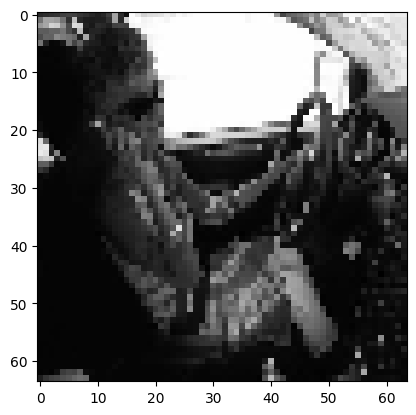

1/1 [==============================] - 0s 26ms/step
Y prediction: [[3.9930693e-08 8.7482341e-09 9.9763083e-01 3.9740017e-10 1.1646765e-08
  8.8525292e-07 2.3644182e-03 1.0874761e-07 1.0358197e-06 2.8070863e-06]]
Predicted: Talking on the phone - right


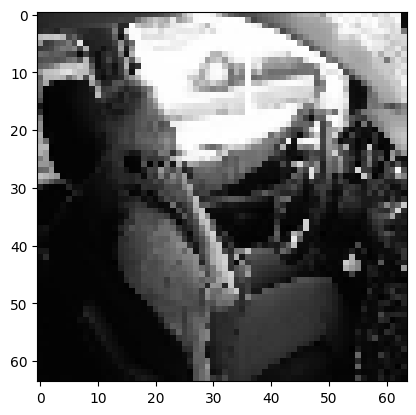

1/1 [==============================] - 0s 28ms/step
Y prediction: [[1.6556523e-03 1.5204403e-04 1.8961747e-04 2.1881920e-06 6.4915009e-03
  2.7574315e-06 9.7878349e-01 1.1116430e-06 1.0739878e-02 1.9817529e-03]]
Predicted: Drinking


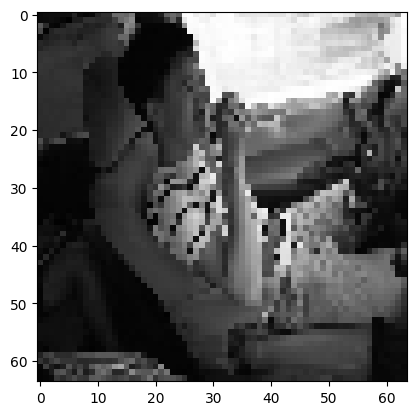

1/1 [==============================] - 0s 26ms/step
Y prediction: [[2.5397489e-02 4.2428608e-05 3.1190741e-04 4.0982781e-07 6.8559065e-03
  2.8204229e-05 7.1116519e-01 5.5663163e-09 3.4729239e-02 2.2146924e-01]]
Predicted: Drinking


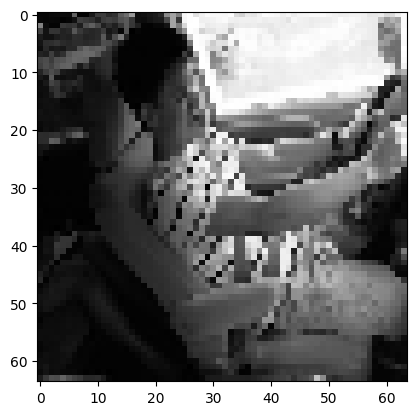

1/1 [==============================] - 0s 24ms/step
Y prediction: [[1.6042907e-07 7.1954764e-10 4.5972550e-01 2.6536155e-09 3.7792679e-02
  5.8907306e-05 5.0222981e-01 3.3090355e-09 1.5872848e-04 3.4149718e-05]]
Predicted: Drinking


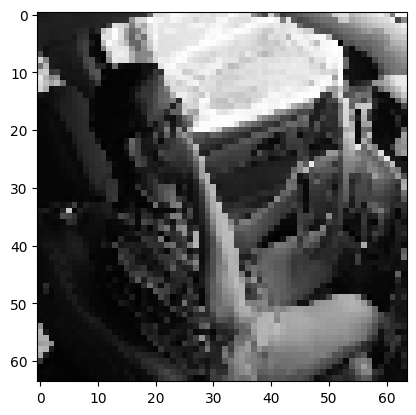

In [21]:
for i in range(10):
    plot_test_class(model, test_files, i)

In [22]:
model.save('ddm.keras')